# health beauty 상품들의 낮은 리뷰 점수의 원인

In [12]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)

In [19]:
SILVERDEV_DIR = "../../../downloads/silver_dev"
review_inference = pd.read_csv(f"{SILVERDEV_DIR}/review_inference.tsv", sep='\t')
review_metadata = pd.read_csv(f"{SILVERDEV_DIR}/review_metadata.tsv", sep='\t')

In [ ]:
BRONZE_DIR = "../../../downloads/olist_redefined"

product = pd.read_csv(f"{BRONZE_DIR}/product.tsv", sep='\t').drop_duplicates()
order_item = pd.read_csv(f"{BRONZE_DIR}/order_item.tsv", sep='\t').drop_duplicates()

,product_id,weight_g,length_cm,height_cm,width_cm,category
0,18ea29d5e42eea2c720cafb650f572f3,50.0,16.0,6.0,13.0,agro_industry_and_commerce
1,a79e27ad902bfc67386ea63ed1ef7a08,100.0,16.0,5.0,11.0,agro_industry_and_commerce
2,a0fe1efb855f3e786f0650268cd77f44,125.0,20.0,4.0,13.0,agro_industry_and_commerce
3,ac4bd2aec3f990363aa853e4f17709d3,150.0,18.0,8.0,13.0,agro_industry_and_commerce
4,a6bfd5412c292e6ab465ba7d7f794727,200.0,16.0,2.0,20.0,agro_industry_and_commerce
...,...,...,...,...,...,...
32946,8ef13bdd5d6da4bc50df1aaa486bf922,25800.0,34.0,84.0,54.0,NaN
32947,ea11e700a343582ad56e4c70e966cb36,26000.0,67.0,57.0,46.0,NaN
32948,ace8fb267a4f76c58dad79d0171f6812,26950.0,65.0,79.0,29.0,NaN
32949,ceeba7d5636e59173cc5f484e913db3d,30000.0,65.0,65.0,65.0,NaN


In [42]:
product.head(1)

,product_id,weight_g,length_cm,height_cm,width_cm,category
0,18ea29d5e42eea2c720cafb650f572f3,50.0,16.0,6.0,13.0,agro_industry_and_commerce


In [44]:
TARGET_CATEGORY = 'health_beauty'

In [47]:
target_product = product[product['category'] == TARGET_CATEGORY]

In [52]:
target_order_item = order_item[order_item['product_id'].isin(target_product['product_id'])]
target_order_item.head(2)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
8,0005a1a1728c9d785b8e2b08b904576c,1,310ae3c140ff94b03219ad0adc3c778f,a416b6a846a11724393025641d4edd5e,2018-03-26 18:31:29,145.95,11.65
10,00061f2a7bc09da83e415a52dc8a4af1,1,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,2018-03-29 22:28:09,59.99,8.88


In [97]:
TARGET_SCORE = [4,5]

In [98]:
target_review = review_metadata[review_metadata['review_score'].isin(TARGET_SCORE)]
target_review = target_review[target_review['order_id'].isin(target_order_item['order_id'])]

target_review.shape

(7022, 5)

In [99]:
filter_condition = review_inference['review_id'].isin(target_review['review_id'])
target_review_comment = review_inference[filter_condition]
target_review_comment.shape

(3377, 7)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/jmhwang/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jmhwang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jmhwang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jmhwang/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


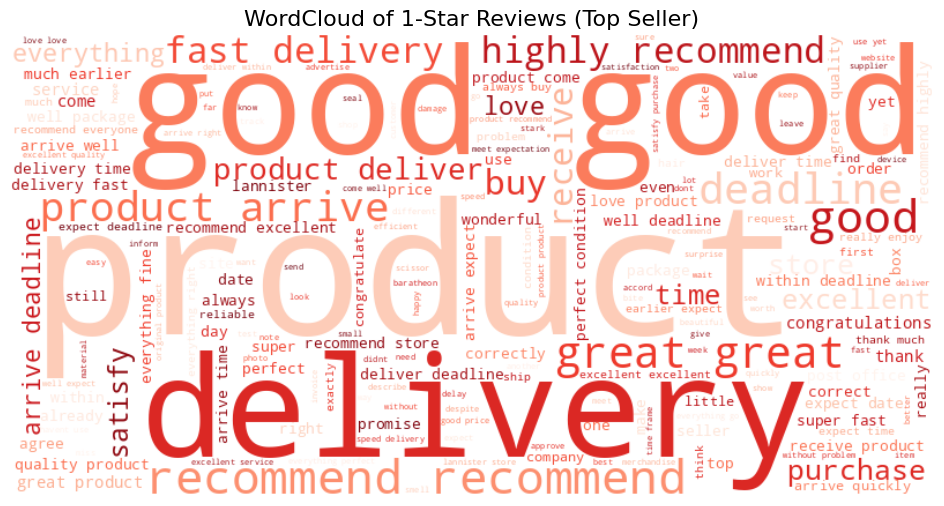

In [100]:
# Import libraries
import re
import sys
import nltk

from wordcloud import WordCloud
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# # Setup NLTK data path (if needed)
# nltk.data.path.append('/home/jmhwang/nltk_data')
# sys.path.append("/home/jmhwang/nltk_data")

# Initialize components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define functions
def lemmatize_tokens(tokens):
    """Apply lemmatization to tokens"""
    return [lemmatizer.lemmatize(token, pos='v') for token in tokens]

def preprocess(text):
    """Preprocess text: lowercase, remove non-alphabetic chars, tokenize, remove stopwords, lemmatize"""
    if not isinstance(text, str):
        return ''
    
    # Convert to lowercase and remove non-alphabetic characters
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and short words
    tokens = [t for t in tokens if t not in stop_words and len(t) > 2]
    
    # Lemmatize
    tokens = lemmatize_tokens(tokens)
    
    return ' '.join(tokens)

# Process text data
text_corpus = target_review_comment['eng'].dropna().apply(preprocess).str.cat(sep=' ')

# Generate word cloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='Reds'
).generate(text_corpus)

# Visualize
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of 1-Star Reviews (Top Seller)", fontsize=16)
plt.show()

In [101]:
from collections import Counter

# 모든 토큰 모으기
tokens = text_corpus.split()

# 빈도 계산
word_freq = Counter(tokens)
len(word_freq)

1313

In [102]:
# 상위 20개 키워드 추출
top_words = word_freq.most_common(20)
top_words = top_words[1:]   # top_words[0] == 'product'


In [103]:
words, freqs = zip(*top_words)

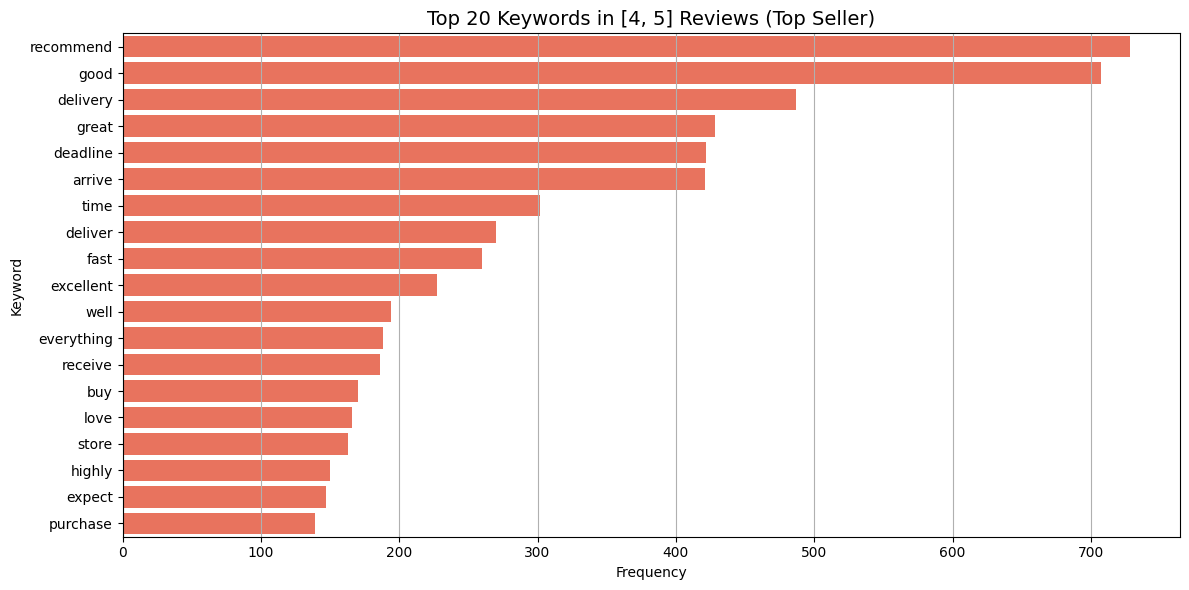

In [104]:

plt.figure(figsize=(12, 6))
sns.barplot(x=list(freqs), y=list(words), color='tomato')  # 수평 막대
plt.title(f"Top 20 Keywords in {TARGET_SCORE} Reviews (Top Seller)", fontsize=14)
plt.xlabel("Frequency")
plt.ylabel("Keyword")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


낮은 리뷰의 주요 원인: 배송